# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from transformers import AlbertTokenizer, DistilBertTokenizer, BertTokenizer, AlbertForSequenceClassification, DistilBertForSequenceClassification, BertForSequenceClassification, AdamW
from tqdm.notebook import tqdm

c:\Users\sadai\anaconda3\envs\datasci\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir('..') #change directory from \notebooks to \Cluster_Obfuscation
os.getcwd()

'c:\\Users\\sadai\\Desktop\\Cluster_Obfuscation'

# Shared Preprocessing

## Read in Dataset

In [5]:
train_data = pd.read_csv(r".\data\raw\c50.csv")
test_data = pd.read_csv(r".\data\raw\c50_Test.csv")
test_data = test_data.drop(test_data.columns[0:2], axis=1)

In [7]:
test_data.head()

,Text,true-author
0,China and Britain agreed on Wednesday to relea...,candidate00046
1,The Federal Reserve may not be taking adequate...,candidate00001
2,Britain's motor industry reported 1996 car reg...,candidate00009
3,When the former Czechoslovak diplomat Josef Ko...,candidate00019
4,China is building a network of major toll high...,candidate00012


In [8]:
test_data = test_data.rename(columns={'true-author': 'Author'})
test_data.head()

,Text,Author
0,China and Britain agreed on Wednesday to relea...,candidate00046
1,The Federal Reserve may not be taking adequate...,candidate00001
2,Britain's motor industry reported 1996 car reg...,candidate00009
3,When the former Czechoslovak diplomat Josef Ko...,candidate00019
4,China is building a network of major toll high...,candidate00012


## Combine Dataset

In [10]:
full_data = pd.concat([train_data, test_data])
full_data.reset_index(drop=True, inplace=True)
full_data

,Author,Text
0,candidate00001,The Internet may be overflowing with new techn...
1,candidate00001,The U.S. Postal Service announced Wednesday a ...
2,candidate00001,Elementary school students with access to the ...
3,candidate00001,An influential Internet organisation has backe...
4,candidate00001,An influential Internet organisation has backe...
...,...,...
4995,candidate00018,Britain's big banks look set to raise profits ...
4996,candidate00047,After two years of hype and euphoria about the...
4997,candidate00002,Czech annual average consumer inflation eased ...
4998,candidate00037,"Kellogg Co, whose profits for 1996 are under p..."


## Preprocess Text

In [11]:
# remove leading and trailing whitespace
full_data['Text'] = full_data['Text'].str.strip()

# # replace multiple spaces with a single space
full_data['Text'] = full_data['Text'].str.replace(r'\s+', ' ')

In [12]:
full_data.head()

,Author,Text
0,candidate00001,The Internet may be overflowing with new techn...
1,candidate00001,The U.S. Postal Service announced Wednesday a ...
2,candidate00001,Elementary school students with access to the ...
3,candidate00001,An influential Internet organisation has backe...
4,candidate00001,An influential Internet organisation has backe...


In [13]:
word_count_func = lambda x: len(x.split())
# train_data['word_count'] = train_data['Text'].apply(word_count_func)
# test_data['word_count'] = test_data['Text'].apply(word_count_func)
full_data['word_count'] = full_data['Text'].apply(word_count_func)

In [14]:
full_data.Author.value_counts()
full_data.groupby('Author').word_count.mean()

Author
candidate00001    28.39
candidate00002    29.21
candidate00003    30.92
candidate00004    30.97
candidate00005    32.81
candidate00006    30.47
candidate00007    29.36
candidate00008    33.58
candidate00009    34.28
candidate00010    30.19
candidate00011    30.10
candidate00012    31.64
candidate00013    28.52
candidate00014    30.60
candidate00015    31.22
candidate00016    31.26
candidate00017    31.84
candidate00018    31.57
candidate00019    31.85
candidate00020    29.55
candidate00021    30.46
candidate00022    29.66
candidate00023    31.18
candidate00024    30.90
candidate00025    30.23
candidate00026    27.73
candidate00027    25.97
candidate00028    33.71
candidate00029    32.18
candidate00030    30.25
candidate00031    30.18
candidate00032    28.48
candidate00033    29.67
candidate00034    30.61
candidate00035    32.32
candidate00036    30.73
candidate00037    29.62
candidate00038    32.94
candidate00039    30.96
candidate00040    30.41
candidate00041    30.80
candidate

c:\Users\sadai\anaconda3\envs\datasci\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sadai\anaconda3\envs\datasci\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x800 with 0 Axes>

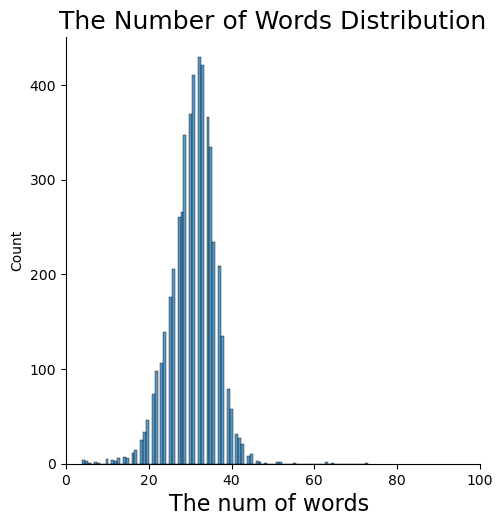

In [15]:
plt.figure(figsize= (8, 8))

sns.displot(full_data['word_count'])

plt.xlim(0, 100)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

Due to the small set of authors, I will initially use the whole dataset.

In [16]:
# Categorical encoding for author labels
authors = pd.Categorical(full_data['Author']).categories
full_data['encoded_Author'] = pd.Categorical(full_data['Author'], categories=authors).codes
full_data

,Author,Text,word_count,encoded_Author
0,candidate00001,The Internet may be overflowing with new techn...,18,0
1,candidate00001,The U.S. Postal Service announced Wednesday a ...,25,0
2,candidate00001,Elementary school students with access to the ...,30,0
3,candidate00001,An influential Internet organisation has backe...,23,0
4,candidate00001,An influential Internet organisation has backe...,23,0
...,...,...,...,...
4995,candidate00018,Britain's big banks look set to raise profits ...,37,17
4996,candidate00047,After two years of hype and euphoria about the...,31,46
4997,candidate00002,Czech annual average consumer inflation eased ...,19,1
4998,candidate00037,"Kellogg Co, whose profits for 1996 are under p...",37,36


## Split Data

In [17]:
X = full_data['Text'].to_list()
y = full_data['encoded_Author'].to_list()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
len(X_train), len(X_test),len(X_train), len(y_test)
# len(X_train), len(X_train)

(4500, 500, 4500, 500)

In [19]:
# Save cleaned data
training_dataset = pd.DataFrame({'Text': X_train, 'encoded_Author': y_train})
training_dataset.to_csv(r".\data\cleaned_data\cleaned_c50_train.csv")    
testing_dataset = pd.DataFrame({'Text': X_test, 'encoded_Author': y_test})
testing_dataset.to_csv(r".\data\cleaned_data\cleaned_c50_test.csv")   

# Tokenization

In [24]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',  do_lower_case=True)
# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2',  do_lower_case=True)
MAX_LENGTH = full_data['word_count'].max()


In [25]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=MAX_LENGTH, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    # inputs_embeds = encoded_dict['inputs_embeds']
    attention_masks = encoded_dict['attention_mask']
    # texts = docs
    # print(encoded_dict)
    return input_ids, attention_masks#, texts
# input_ids, attention_masks = encode(texts)
# labels = torch.tensor(labels)  

In [26]:
# Check for missing values in the labels
if full_data['encoded_Author'].isnull().sum() > 0:
    print('There are missing values in the labels!')
else:
    print('No missing values in the labels')

No missing values in the labels


In [32]:
X_train_ids, X_train_masks = encode(full_data['Text'])
X_test_ids, X_test_masks = encode(full_data['Text'])
y_train = torch.tensor(y_train).long()  # convert to long tensor
y_test = torch.tensor(y_test).long() # convert to long tensor  

# Save Tokenized Data

In [34]:
torch.save(X_train_ids, "./data/cleaned_data/tokenized_data/X_train_ids.pt")
torch.save(X_test_ids, "./data/cleaned_data/tokenized_data/X_test_ids.pt")
torch.save(X_train_masks, "./data/cleaned_data/tokenized_data/X_train_masks.pt")
torch.save(X_test_masks, "./data/cleaned_data/tokenized_data/X_test_masks.pt")
np.save("./data/cleaned_data/tokenized_data/y_train_author.npy", y_train)
np.save("./data/cleaned_data/tokenized_data/y_test_author.npy", y_test)